In [1]:
# pip install contextily

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
import contextily as ctx
import numpy as np
import os
import json
import uuid

# Define bounding box of Bali in EPSG:4326 (WGS84)
minx, miny = 114.403381, -8.853592  # SW corner
maxx, maxy = 115.716248, -8.035842  # NE corner

# Create initial bounding box and GeoDataFrame
bbox = gpd.GeoDataFrame(
    {"geometry": [box(minx, miny, maxx, maxy)]},
    crs="EPSG:4326"
)

# Reproject to UTM Zone 50S (meters)
bbox_utm = bbox.to_crs("EPSG:32750")

# Extract bounds in meters
xmin, ymin, xmax, ymax = bbox_utm.total_bounds

# Define patch size in meters (e.g. 4 km x 4 km)
patch_size_m = 10240

# Generate patches using meter-based loop
patches = []
x = xmin
while x < xmax:
    y = ymin
    while y < ymax:
        patch = box(x, y, x + patch_size_m, y + patch_size_m)
        patches.append(patch)
        y += patch_size_m
    x += patch_size_m

# Create GeoDataFrame with patches and reproject back to WGS84 for saving/plotting
patches_gdf = gpd.GeoDataFrame({'geometry': patches}, crs="EPSG:32750").to_crs("EPSG:4326")

In [8]:
# Load Bali land shapefile and ensure same CRS
bali_land = gpd.read_file('../data/masks/bali_merged.geojson')
bali_land = bali_land.to_crs(patches_gdf.crs)

# Filter patches intersecting with land
patches_on_land = gpd.sjoin(patches_gdf, bali_land, how='inner', predicate='intersects')
patches_on_land = patches_on_land.drop(columns='index_right')

# Convert to Web Mercator for plotting
patches_on_land = patches_on_land.to_crs(epsg=3857)

print(f"Number of raster patches: {len(patches_on_land)}")

Number of raster patches: 88


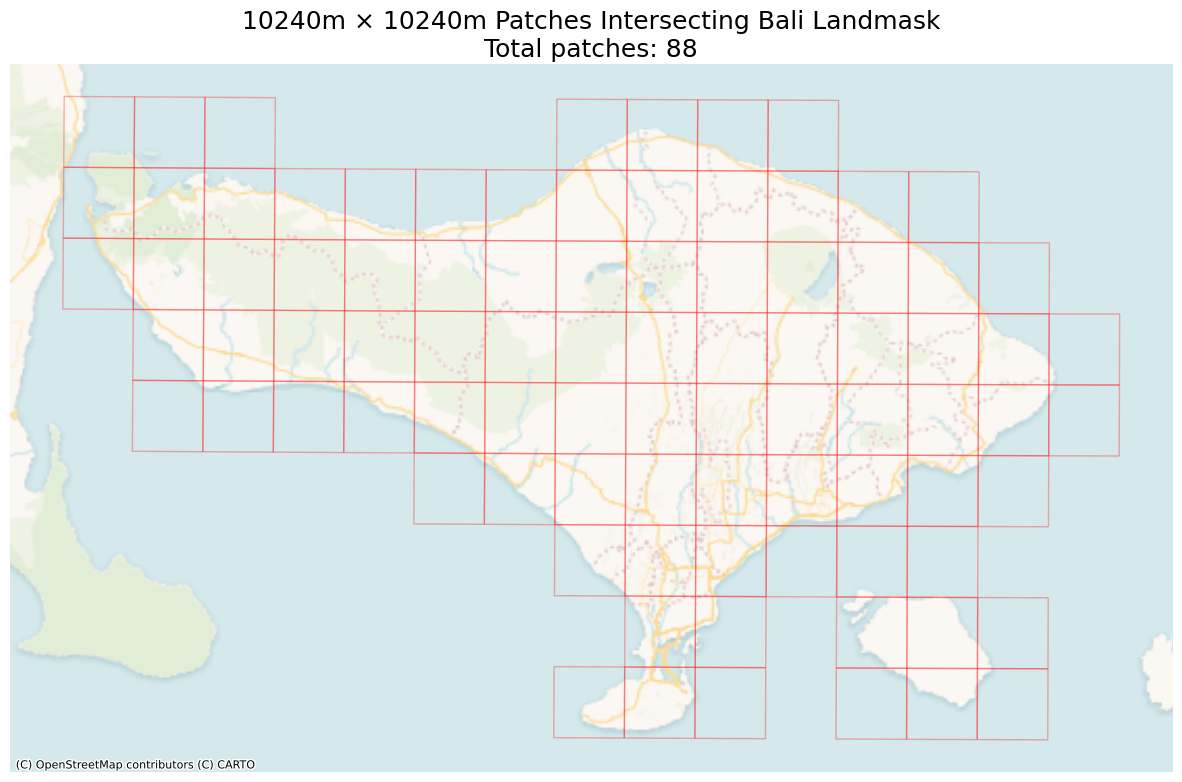

In [9]:
# Plot
fig, ax = plt.subplots(figsize=(15, 15))

# Plot the patches
patches_on_land.plot(ax=ax, facecolor='none', edgecolor='red', alpha=0.3)
# Plot the land mask
# ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels)

# Plot Decorations
ax.set_axis_off()

# Add dynamic title including patch size and count
total_patches = len(patches_on_land)
plt.title(f"{patch_size_m}m × {patch_size_m}m Patches Intersecting Bali Landmask\nTotal patches: {total_patches}", fontsize=18)

plt.show()

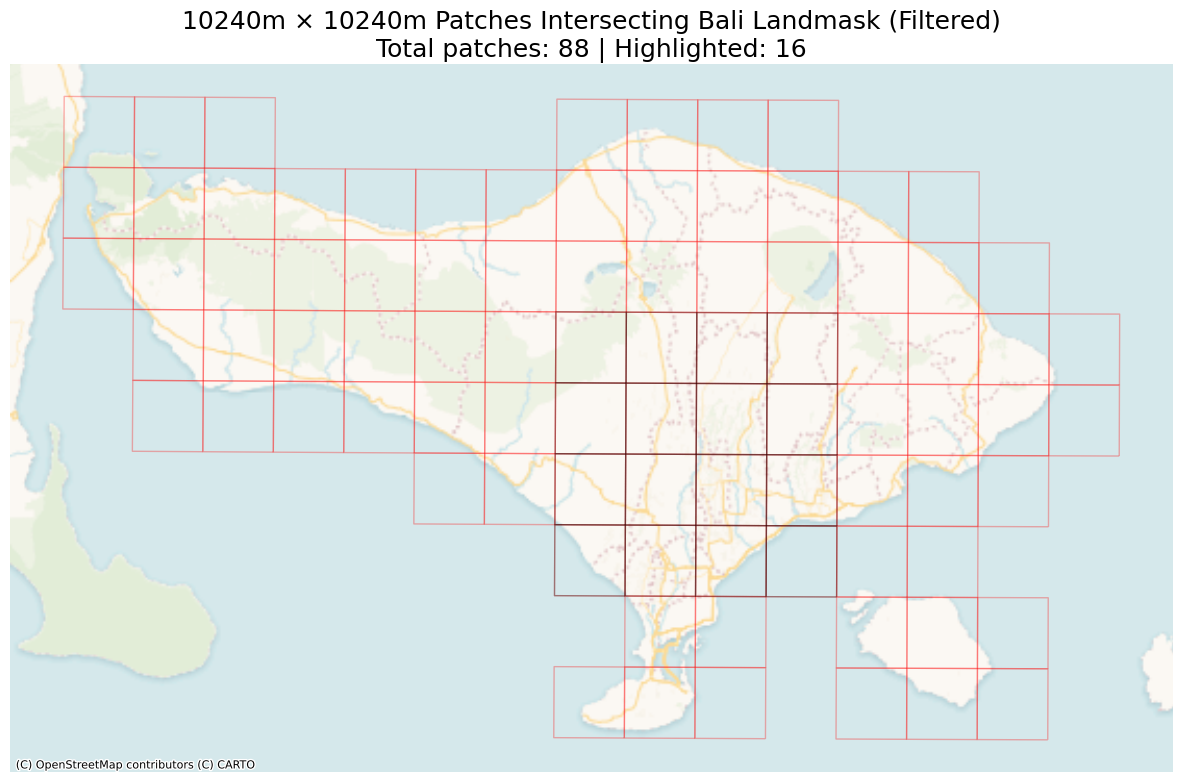

In [10]:
import matplotlib.pyplot as plt
from shapely.geometry import box
import contextily as ctx

# Define the filter bbox in EPSG:3857 (Web Mercator)
filter_bbox_3857 = box(12809890.4777, -967539.9040, 12842414.4333, -935130.6040)

# Filter patches within bbox
highlighted_patches = patches_on_land[patches_on_land.intersects(filter_bbox_3857)]

# Plot all patches and highlight those in the bbox
fig, ax = plt.subplots(figsize=(15, 15))

# All patches: red outline
patches_on_land.plot(ax=ax, facecolor='none', edgecolor='red', alpha=0.3, linewidth=1)

# Highlighted patches: blue outline
highlighted_patches.plot(ax=ax, facecolor='none', edgecolor='black', alpha=0.3, linewidth=1)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels)

# Decorations
ax.set_axis_off()
plt.title(
    f"{patch_size_m}m × {patch_size_m}m Patches Intersecting Bali Landmask (Filtered)\n"
    f"Total patches: {len(patches_on_land)} | Highlighted: {len(highlighted_patches)}",
    fontsize=18
)
plt.show()


In [11]:
# ---- Settings ----
output_dir = "../data/patches"
os.makedirs(output_dir, exist_ok=True)

# Assign unique IDs with UUID to all patches
patches_on_land = patches_on_land.reset_index(drop=True)
patches_on_land["patch_id"] = patches_on_land.index.map(
    lambda i: f"patch_{i:05d}_{uuid.uuid4().hex[:8]}"
)

# Filter patches that intersect with the target bbox
highlighted_patches = patches_on_land[patches_on_land.intersects(filter_bbox_3857)].copy()

# Save all land-intersecting patches with unique ID
patches_on_land.to_file(os.path.join(output_dir, "patches_on_land.geojson"), driver="GeoJSON")

# Save only filtered subset
highlighted_patches.to_file(os.path.join(output_dir, "highlighted_patches.geojson"), driver="GeoJSON")

# Save export metadata
metadata = {
    "crs": "EPSG:3857",
    "patch_km": patch_size_m / 1000,
    "patch_size_meters": patch_size_m,
    "projection": "Web Mercator",
    "highlight_bbox_epsg3857": {
        "xmin": filter_bbox_3857.bounds[0],
        "ymin": filter_bbox_3857.bounds[1],
        "xmax": filter_bbox_3857.bounds[2],
        "ymax": filter_bbox_3857.bounds[3],
    },
    "total_patches_on_land": len(patches_on_land),
    "highlighted_patches_count": len(highlighted_patches),
    "patch_id_format": "patch_00000_uuid (e.g., patch_00042_a1b2c3d4)"
}

with open(os.path.join(output_dir, "metadata.json"), "w") as f:
    json.dump(metadata, f, indent=4)

print("✅ Export complete:")
print(f"• patches_on_land.geojson → {len(patches_on_land)} patches")
print(f"• highlighted_patches.geojson → {len(highlighted_patches)} patches")
print(f"• metadata.json saved to: {output_dir}")


✅ Export complete:
• patches_on_land.geojson → 88 patches
• highlighted_patches.geojson → 16 patches
• metadata.json saved to: ../data/patches
